# KNN, рак и спам
__Суммарное количество баллов: 12__

В этом домашнем задании Вам предлагается при помощи классификации методом k ближайших соседей научиться отличать тип опухоли в организме, а так же определять сообщения со спамом

In [ ]:
import numpy as np
import random
import matplotlib.pyplot as plt
import matplotlib
import copy
import pandas
from typing import NoReturn, Tuple, List
from collections import Counter
from heapq import merge

### Задание 1 (1 балл)
Для начала работы нам необходимо научиться читать набор данных. Всего мы будем работать с двумя наборами данных.

__Cancer.csv__ - выборка данных о пациентах с доброкачественными и злокачественными опухолями. Задача - научиться их отличать.

__Spam.csv__ - набор данных большего размера. Он содержит некоторую статистику по сообщениям, а так же метку, является ли сообщение спамом. Задача - научиться автоматически отличать спам от обычных сообщений.

Реализуйте методы `read_cancer_dataset` и `read_spam_dataset`. Каждый из них принимает на вход путь к набору данных и возвращает выборку `X` и соответствующие метки `y`. Набор данных должен быть упорядочен случайно, т.е. необходимо сделать shuffle.

In [ ]:
from task import read_cancer_dataset, read_spam_dataset

ModuleNotFoundError: ignored

In [ ]:
def read_cancer_dataset(path_to_csv: str) -> Tuple[np.array, np.array]:
    """
     
    Parameters
    ----------
    path_to_csv : str
        Путь к cancer датасету.

    Returns
    -------
    X : np.array
        Матрица признаков опухолей.
    y : np.array
        Вектор бинарных меток, 1 соответствует доброкачественной опухоли (M), 
        0 --- злокачественной (B).

    
    """
    dataframe = pandas.read_csv(path_to_csv)
    X = np.array(dataframe.drop('label', axis=1))
    y = np.array(dataframe['label'])
    y[y == 'M'] = 1
    y[y == 'B'] = 0
    return (X, y)

def read_spam_dataset(path_to_csv: str) -> Tuple[np.array, np.array]:
    """
     
    Parameters
    ----------
    path_to_csv : str
        Путь к spam датасету.

    Returns
    -------
    X : np.array
        Матрица признаков сообщений.
    y : np.array
        Вектор бинарных меток, 
        1 если сообщение содержит спам, 0 если не содержит.
    
    """
    dataframe = pandas.read_csv(path_to_csv)
    X = np.array(dataframe.drop('label', axis=1))
    y = np.array(dataframe['label'])
    return (X, y)

In [ ]:
X_cancer, y_cancer = read_cancer_dataset("cancer.csv")
X_spam, y_spam = read_spam_dataset("spam.csv")

In [ ]:
X_cancer

array([[1.799e+01, 1.038e+01, 1.228e+02, ..., 2.654e-01, 4.601e-01,
        1.189e-01],
       [2.057e+01, 1.777e+01, 1.329e+02, ..., 1.860e-01, 2.750e-01,
        8.902e-02],
       [1.969e+01, 2.125e+01, 1.300e+02, ..., 2.430e-01, 3.613e-01,
        8.758e-02],
       ...,
       [1.660e+01, 2.808e+01, 1.083e+02, ..., 1.418e-01, 2.218e-01,
        7.820e-02],
       [2.060e+01, 2.933e+01, 1.401e+02, ..., 2.650e-01, 4.087e-01,
        1.240e-01],
       [7.760e+00, 2.454e+01, 4.792e+01, ..., 0.000e+00, 2.871e-01,
        7.039e-02]])

### Задание 2  (1 балл)
Начиная работать с данными, нам необходимо их предобработать и подготовить. В частности, нам необходимо разделить выборку на две: тренировочную и тестовую. Тренировочная выборка необходима для обучения алгоритма, а тестовая для проверки результатов обучения. Обычно используют коэффициент разделения `0.9`.

Необходимо вернуть кортеж из `X_train`, `y_train`, `X_test` и `y_test`

In [ ]:
def train_test_split(X: np.array, y: np.array, ratio: float) -> Tuple[np.array, np.array, np.array, np.array]:
    """

    Parameters
    ----------
    X : np.array
        Матрица признаков.
    y : np.array
        Вектор меток.
    ratio : float
        Коэффициент разделения.

    Returns
    -------
    X_train : np.array
        Матрица признаков для train выборки.
    y_train : np.array
        Вектор меток для train выборки.
    X_test : np.array
        Матрица признаков для test выборки.
    y_test : np.array
        Вектор меток для test выборки.

    """
    
    ratio = min(1, ratio)
    ratio = max(0, ratio)
    samplesAmount = len(y)
    p = np.random.permutation(samplesAmount)
    X = X[p]
    y = y[p]
    limit = int(samplesAmount * ratio)
    X_train = X[:limit]
    y_train = y[:limit]
    X_test = X[limit:]
    y_test = y[limit:]
    return (X_train, y_train, X_test, y_test)

In [ ]:
X_cancer_train, y_cancer_train, X_cancer_test, y_cancer_test = train_test_split(X_cancer, y_cancer, 0.9)


In [ ]:
from task import train_test_split

### Задание 3 (2 балла)
Также прежде чем приступать к решению задачи, нам необходимо определиться с метриками, которые позволят нам оценить полученное решение. Для задач классификации мы можем использовать precision, recall и accuracy. Эти метрики считаются для каждого класса.

Метод возвращает:

* Вектор __Precision__, каждый из элементов которого равен значению метрики precision для соответствующего класса. 

* Вектор __Recall__, каждый из элементов которого равен значению метрики recall для соответствующего класса.

* __Accuracy__ - число, которое равно отношению правильно классифицированных элементов выборке к размеру выборки.

In [ ]:
def get_precision_recall_accuracy(y_pred: np.array, y_true: np.array) -> Tuple[np.array, np.array, float]:
    """

    Parameters
    ----------
    y_pred : np.array
        Вектор классов, предсказанных моделью.
    y_true : np.array
        Вектор истинных классов.

    Returns
    -------
    precision : np.array
        Вектор с precision для каждого класса.
    recall : np.array
        Вектор с recall для каждого класса.
    accuracy : float
        Значение метрики accuracy (одно для всех классов).

    """
    classes = np.unique(y_true) #in the suggestion every one is represented
    TP = Counter()
    FP = Counter()
    TN = Counter()
    FN = Counter()
    amount = len(classes)

    precs = np.zeros(amount)
    recs = np.zeros(amount)
    ac = 0

    TPS = 0
    for i in range(len(y_true)):
      curPred = y_pred[i]
      curTrue = y_true[i]
      if (curPred == curTrue):
       TP[curTrue] += 1
       for cls in classes:
        TN[cls] += 1
       TN[curTrue] -= 1
      else:
        FN[curTrue] += 1
        FP[curPred] += 1
        for cls in classes:
          TN[cls] += 1
        TN[curPred] -= 1
        TN[curTrue] -= 1
    for i in range(amount):
      precs[i] = TP[i] / max(1, TP[i] + FP[i])
      recs[i] = TP[i] / max(1, TP[i] + FN[i])
      TPS += TP[i]
    ac = TPS / len(y_true)

    return precs, recs, ac

In [ ]:
from task import get_precision_recall_accuracy

ModuleNotFoundError: ignored

Теперь, имея этот метод, мы можем построить кривые зависимости Precision, Recall и Accuracy от параметра `k`

In [ ]:
def plot_precision_recall(X_train, y_train, X_test, y_test, max_k=30):
    ks = list(range(1, max_k + 1))
    classes = len(np.unique(list(y_train) + list(y_test)))
    precisions = [[] for _ in range(classes)]
    recalls = [[] for _ in range(classes)]
    accuracies = []
    for k in ks:
        classifier = KNearest(k)
        classifier.fit(X_train, y_train)
        y_pred = classifier.predict(X_test)
        precision, recall, acc = get_precision_recall_accuracy(y_pred, y_test)
        for c in range(classes):
            precisions[c].append(precision[c])
            recalls[c].append(recall[c])
        accuracies.append(acc)
    def plot(x, ys, ylabel, legend=True):        
        plt.figure(figsize = (12, 3))
        plt.xlabel("K")
        plt.ylabel(ylabel)
        plt.xlim(x[0], x[-1])
        plt.ylim(np.min(ys)-0.01, np.max(ys)+0.01)
        for cls, cls_y in enumerate(ys):
            plt.plot(x, cls_y, label="Class " + str(cls))
        if legend:
            plt.legend()
        plt.tight_layout()
        plt.show()
    
    plot(ks, recalls, "Recall")
    plot(ks, precisions, "Precision")
    plot(ks, [accuracies], "Accuracy", legend=False)

Также для оценки качества классификации построим __ROC-кривую__. Она отражает зависимость __True Positive Rate__ (TPR) от __False Positive Rate__ (FPR) для заранее фиксированного класса. Чем график выше побочной диагонали - тем лучше.

In [ ]:
def plot_roc_curve(X_train, y_train, X_test, y_test, max_k=30):
    positive_samples = sum(1 for y in y_test if y == 0)
    ks = list(range(1, max_k + 1))
    curves_tpr = []
    curves_fpr = []
    colors = []
    for k in ks:
        colors.append([k / ks[-1], 0, 1 - k / ks[-1]])
        knearest = KNearest(k)
        knearest.fit(X_train, y_train)
        p_pred = [p[0] for p in knearest.predict_proba(X_test)]
        tpr = []
        fpr = []
        for w in np.arange(-0.01, 1.02, 0.01):
            y_pred = [(0 if p > w else 1) for p in p_pred]
            tpr.append(sum(1 for yp, yt in zip(y_pred, y_test) if yp == 0 and yt == 0) / positive_samples)
            fpr.append(sum(1 for yp, yt in zip(y_pred, y_test) if yp == 0 and yt != 0) / (len(y_test) - positive_samples))
        curves_tpr.append(tpr)
        curves_fpr.append(fpr)
    plt.figure(figsize = (7, 7))
    for tpr, fpr, c in zip(curves_tpr, curves_fpr, colors):
        plt.plot(fpr, tpr, color=c)
    plt.plot([0, 1], [0, 1], linestyle="--")
    plt.xlabel("False positive rate")
    plt.ylabel("True positive rate")
    plt.xlim(-0.01, 1.01)
    plt.ylim(-0.01, 1.01)
    plt.tight_layout()
    plt.show()

### Задание 4 (5 баллов)
Теперь приступим к реализации классификатора. В этот раз будем использовать классификацию методом k средних. Поскольку основной решаемой задачий во время классификации этим методом является поиск ближайших соседей, а набор данных может быть достаточно большим, наивная реализация будет работать очень долго.

Одним из способов решить эту проблему является __KD-дерево__. Оно позволяет значительно ускорить поиск ближайших соседей. Реализуйте построение KD-дерева и выполнение запросов на поиск k ближайших соседей.

Метод `__init__` должен принимать на вход набор точек `X`, по которому будет строиться дерево, а так же размер листов `leaf_size` построенного дерева.

Метод `query` должен принимать на вход набор точек `X`, для каждой из которых необходимо найти `k` ближайших соседей.

In [ ]:
from task import KDTree

Поскольку данная струкутра данных является сложной, ее стоит протестировать отдельно. Для этого проведем тестирование с небольшим набором случайных точек. Если после выполнение вывод пуст, то KD-дерево скорее всего работает правильно.

In [ ]:
# Task 4

class Node:
    def __init__(self, inds, X: np.array, leaf_size: int = 40):
        self.inds = inds
        self.treshold = X
        self.leaf_size = leaf_size
        self.leftNode = None
        self.rightNode = None

    def build(self, depth=1, curColumn = 0):
        column = self.treshold[: , curColumn]
        #med = np.nanquantile(column, 0.5)
        med =np.median(column)
        self.med = med
        self.curColumn = curColumn
        self.sz = len(self.treshold)

        if (depth == 10):
          return

        leftTreshold = []
        leftInds = []

        rightTreshold = []
        rightInds = []

        for i in range(len(self.treshold)):
          if (self.treshold[i][curColumn] <= med):
            leftInds.append(self.inds[i])
            leftTreshold.append(self.treshold[i])
          else:
            rightInds.append(self.inds[i])
            rightTreshold.append(self.treshold[i])

        leftTreshold= np.array(leftTreshold)
        leftInds = np.array(leftInds)

        rightTreshold = np.array(rightTreshold)
        rightInds = np.array(rightInds)

        if (self.leaf_size <= len(leftTreshold) and 1 < len(leftTreshold)):
          self.leftNode = Node(leftInds, leftTreshold, self.leaf_size)
          self.leftNode.build(depth + 1, (curColumn + 1) % len(self.treshold[0]))
        if (self.leaf_size <= len(rightTreshold) and 1 < len(rightTreshold)):
          self.rightNode = Node(rightInds, rightTreshold, self.leaf_size)
          self.rightNode.build(depth + 1, (curColumn + 1) % len(self.treshold[0]))

class KDTree:
    def __init__(self, X: np.array, leaf_size: int = 40):
        """

        Parameters
        ----------
        X : np.array
            Набор точек, по которому строится дерево.
        leaf_size : int
            Минимальный размер листа
            (то есть, пока возможно, пространство разбивается на области, 
            в которых не меньше leaf_size точек).

        Returns
        -------

        """
        self.treshold = X
        self.leaf_size = leaf_size 

        self.node = Node(np.array(list(range(len(X)))), X, leaf_size)
        self.node.build()
    
    def countDistances(self, y: np.ndarray, X: np.ndarray):
        return np.array([np.linalg.norm(y - x) for x in X])

    def queryForOne(self, curNode, x, k):
        if (curNode is None):
           return []
        left, right = curNode.leftNode, curNode.rightNode
        if (curNode.sz <= k or curNode.sz == curNode.leaf_size or (left is None and right is None)):
            dists = self.countDistances(x, curNode.treshold)
            res = []
            for i in range(len(curNode.inds)):
              res.append([curNode.inds[i], dists[i]])
            res = sorted(res, key=lambda x: x[1])
            return res[:k]

        if curNode.med < x[curNode.curColumn]:
            left, right = right, left

        curIndsDists = []
        if (left is not None):
          curIndsDists = self.queryForOne(left, x, k)

        distToMed = np.abs(x[curNode.curColumn] - curNode.med)
        
        maxDist = 0
        if (0 < len(curIndsDists)):
          maxDist = curIndsDists[-1][1]

        if distToMed < maxDist or len(curIndsDists) < k:
          addIndsDists = []
          if (right is not None):
            addIndsDists = self.queryForOne(right, x, k)
          return list(merge(curIndsDists, addIndsDists, key=lambda z: z[1]))[:k]
              
        else:
          return curIndsDists[:k]



    def query(self, X: np.array, k: int = 1) -> List[List]:
        """

        Parameters
        ----------
        X : np.array
            Набор точек, для которых нужно найти ближайших соседей.
        k : int
            Число ближайших соседей.

        Returns
        -------
        list[list]
            Список списков (длина каждого списка k): 
            индексы k ближайших соседей для всех точек из X.

        """
        indsDists = [self.queryForOne(self.node, x, k) for x in X]
        res = []

        for r in indsDists:
          res.append([a for (a,b) in r])
        return res
        

In [ ]:
m = kdt.query([np.array([4, 4, 4])], 150)
print(m)


[[1, 0, 2, 3, 4, 5]]


In [ ]:
def true_closest(X_train, X_test, k):
    result = []
    for x0 in X_test:
        bests = list(sorted([(i, np.linalg.norm(x - x0)) for i, x in enumerate(X_train)], key=lambda x: x[1]))
        bests = [i for i, d in bests]
        result.append(bests[:min(k, len(bests))])
    return result    

X_train = np.random.randn(100, 3)
X_test = np.random.randn(10, 3)
tree = KDTree(X_train, leaf_size=2)
#predicted = tree.query(X_test, k=4, return_distance=False)
predicted = tree.query(X_test, k=4)
true = true_closest(X_train, X_test, k=4)

print(true)
print(predicted)

if np.sum(np.abs(np.array(np.array(predicted).shape) - np.array(np.array(true).shape))) != 0:
    print("Wrong shape")
else:
    errors = sum([1 for row1, row2 in zip(predicted, true) for i1, i2 in zip(row1, row2) if i1 != i2])
    if errors > 0:
        print("Encounted", errors, "errors")


[[59, 76, 31, 14], [85, 4, 3, 71], [51, 77, 9, 73], [42, 28, 94, 2], [54, 95, 60, 92], [81, 76, 52, 14], [80, 56, 62, 51], [63, 2, 23, 42], [72, 21, 96, 10], [32, 48, 70, 0]]
[[59, 76, 31, 14], [85, 4, 3, 71], [51, 77, 9, 73], [42, 28, 94, 2], [54, 95, 60, 92], [81, 76, 52, 14], [80, 56, 62, 51], [63, 2, 23, 42], [72, 21, 96, 10], [32, 48, 70, 0]]


### Задание 5  (3 балла)
Осталось реализовать сам классификатор. Реализуйте его, используя KD-дерево.

Метод `__init__` принимает на вход количество соседей, по которым предсказывается класс, и размер листьев KD-дерева.

Метод `fit` должен по набору данных и меток строить классификатор. 

Метод `predict_proba` должен предсказывать веротности классов для заданного набора данных основываясь на классах соседей

In [ ]:
from task import KNearest

Наконец, протестируем наш классификатор на различных наборах данных. Реализация KNearest должна отработать за разумное время.

In [ ]:
class KNearest:
    def __init__(self, n_neighbors: int = 5, leaf_size: int = 30):
        """

        Parameters
        ----------
        n_neighbors : int
            Число соседей, по которым предсказывается класс.
        leaf_size : int
            Минимальный размер листа в KD-дереве.

        """        
        self.n_neighbors = n_neighbors
        self.leaf_size = leaf_size
    
    def fit(self, X: np.array, y: np.array) -> NoReturn:
        """

        Parameters
        ----------
        X : np.array
            Набор точек, по которым строится классификатор.
        y : np.array
            Метки точек, по которым строится классификатор.

        """        
        self.kDTree = KDTree(X, self.leaf_size)
        self.y = y
        self.uy = np.unique(y)


    def predict_proba(self, X: np.array) -> List[np.array]:
        """

        Parameters
        ----------
        X : np.array
            Набор точек, для которых нужно определить класс.
        
        Returns
        -------
        list[np.array]
            Список np.array (длина каждого np.array равна числу классов):
            вероятности классов для каждой точки X.
            

     """   
        indsList = self.kDTree.query(X, self.n_neighbors)
        res = []
        for inds in indsList:
            c = Counter(self.y[inds])
            res.append(np.array([c[cls] / (max(1, len(inds))) for cls in self.uy]))
        return res

        
    def predict(self, X: np.array) -> np.array:
        """

        Parameters
        ----------
        X : np.array
            Набор точек, для которых нужно определить класс.
        
        Returns
        -------
        np.array
            Вектор предсказанных классов.
            

        """
        return np.argmax(self.predict_proba(X), axis=1)

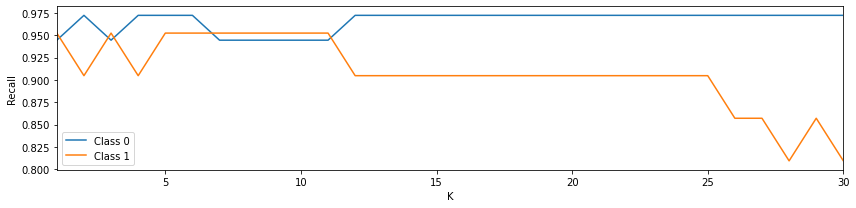

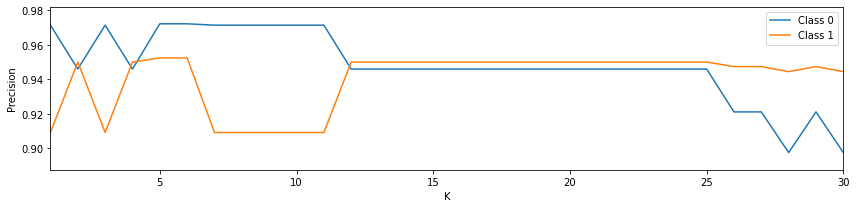

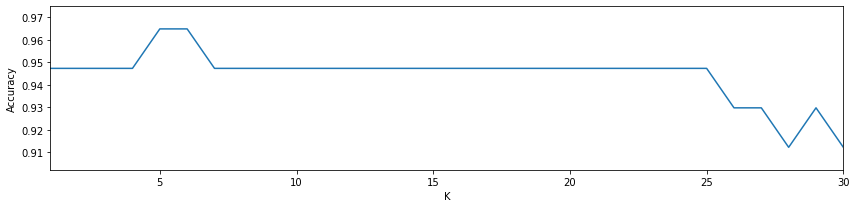

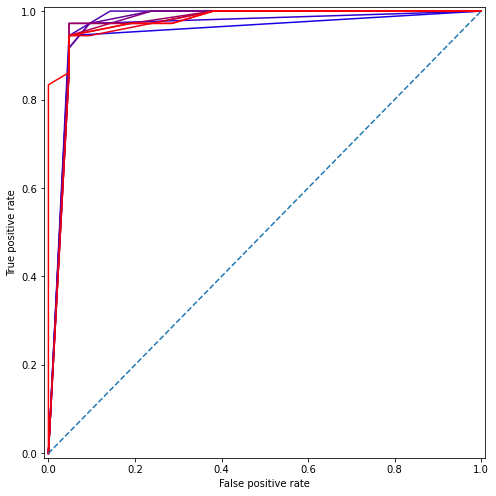

In [ ]:
X, y = read_cancer_dataset("cancer.csv")
X_train, y_train, X_test, y_test = train_test_split(X, y, 0.9)
plot_precision_recall(X_train, y_train, X_test, y_test)
plot_roc_curve(X_train, y_train, X_test, y_test, max_k=10)

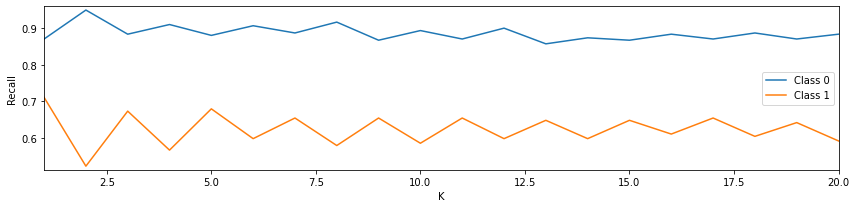

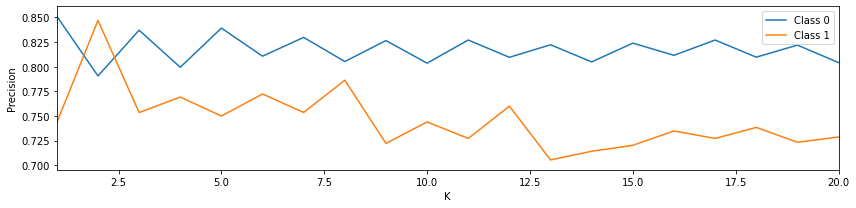

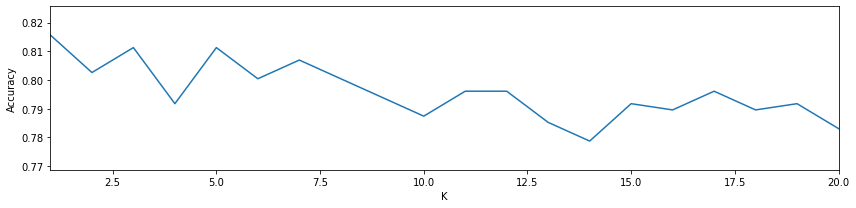

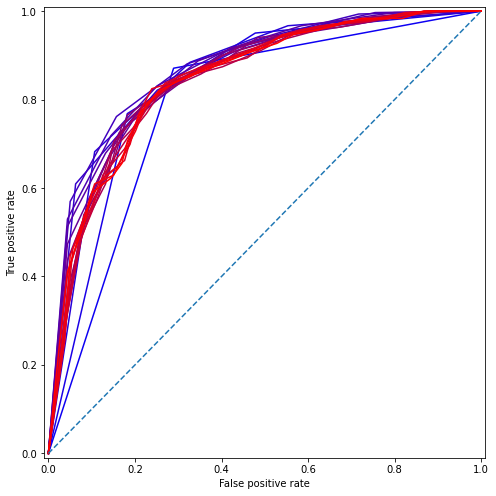

In [ ]:
X, y = read_spam_dataset("spam.csv")
X_train, y_train, X_test, y_test = train_test_split(X, y, 0.9)
plot_precision_recall(X_train, y_train, X_test, y_test, max_k=20)
plot_roc_curve(X_train, y_train, X_test, y_test, max_k=20)